#XGBoost

In [1]:
#import libraries
import pandas as pd
import numpy as np
import yfinance as yf
from google.colab import drive
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import statsmodels.api as sm
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
from joblib import Parallel, delayed, dump, load
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import RobustScaler

Download data from google drive

In [2]:
drive.mount('/content/gdrive')

#import time series
sp500_data = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/sp500_data.csv', index_col=0)
sp500_data = sp500_data.iloc[2:] #remove the first 2 rows that don't contain the time series
sp500_data.index.name = 'Date'
sp500_data.index = pd.to_datetime(sp500_data.index)


#save Close price and Log Returns into a pd.Series
Close_price = sp500_data['Close'].copy().astype(float)
Log_return = sp500_data['Log Return'].copy().astype(float)


#drop columns not needed
sp500_data.drop(['Open', 'High', 'Low', 'Close', 'Log Return'], axis=1, inplace=True)


# #import ARIMA residuals
# residuals = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/close_price_residuals.csv', index_col=0)
# sp500_data.insert(0, 'Residuals', residuals.values)


# #import ARIMA fitted values (predictions on the training set)
# fitted_values = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/fitted_values.csv', index_col=0)


# #import ARIMA predictions on the test set
# ARIMA_predictions = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/arima_predictions.csv', index_col=0).squeeze() #to read as a pd.Series
# ARIMA_predictions.index = pd.to_datetime(ARIMA_predictions.index)


#import SARIMA residuals
residuals = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/SARIMA_residuals.csv', index_col=0, sep=";")
residuals.index = pd.to_datetime(residuals.index, format = "%d/%m/%Y")

#import SARIMA fitted values (predictions on the training set)
SARIMA_fitted_values = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/SARIMA_fitted_values.csv', index_col=0)
SARIMA_fitted_values.index = pd.to_datetime(SARIMA_fitted_values.index)

#import SARIMA predictions on the test set
SARIMA_test_predictions = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/SARIMA_test_predictions.csv', index_col=0).squeeze() #to read as a pd.Series
SARIMA_test_predictions.index = pd.to_datetime(SARIMA_test_predictions.index)

Mounted at /content/gdrive


##Data preprocessing

In [4]:
#univariate sliding window
train_data = residuals.loc[: '2018']
train_data.index = pd.to_datetime(train_data.index)

val_data = residuals.loc['2019': '2021']
val_data.index = pd.to_datetime(val_data.index)

train_val_data = residuals.loc[: '2021']
train_val_data.index = pd.to_datetime(train_val_data.index)

test_data = residuals.loc['2022':]
test_data.index = pd.to_datetime(test_data.index)


#scale the data
# scaler = MinMaxScaler(feature_range=(-1, 1)) #initilise scaler
# scaler = StandardScaler()

scaler = RobustScaler()
train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data.values.reshape(-1, 1)))
val_data_scaled = pd.DataFrame(scaler.transform(val_data.values.reshape(-1, 1)))
train_val_data_scaled = pd.DataFrame(scaler.fit_transform(train_val_data.values.reshape(-1, 1)))
test_data_scaled = pd.DataFrame(scaler.transform(test_data.values.reshape(-1, 1)))


def sliding_windows(data, seq_length):
    X, y = [], []

    for i in range(len(data) - seq_length ):
      _x = data.iloc[i:i+seq_length]
      _y = data.iloc[i + seq_length]
      X.append(_x)
      y.append(_y)

    return np.array(X), np.array(y)


#sliding windows
X_train, y_train  = sliding_windows(train_data_scaled, 10)
X_val, y_val= sliding_windows(val_data_scaled, 10)
X_test, y_test = sliding_windows(test_data_scaled, 10)
X_train_val , y_train_val = sliding_windows(train_val_data_scaled, 10)


# Flatten the sliding windows
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_train_val = X_train_val.reshape(X_train_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)


#convert to Dmatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtrain_val = xgb.DMatrix(X_train_val, label=y_train_val)
dtest = xgb.DMatrix(X_test, label=y_test)

##Find the best hyperparameter using Bayesian Optimization

In [6]:
!pip install arm-mango

In [9]:
from mango import scheduler #to perform Bayesian optimization
from mango.tuner import Tuner
import time
from joblib import Parallel, delayed, dump, load
from scipy.stats import uniform


In [10]:
#parallel bayesian optimization
class OptimizationMangoParallel:
  def __init__(self, njobs: int, configuration_params: dict, dtrain, dval):
      self.conf_dict = configuration_params
      self.njobs = njobs
      # self.dtrain = xgb.DMatrix(X_train, label=y_train)
      # self.dval = xgb.DMatrix(X_val, label=y_val)
      self.dtrain = dtrain
      self.dval = dval
      self.space = {
          "learning_rate": uniform(0.01, 0.5),
          "max_depth": range(5, 15),
          "subsample": uniform(0.7, 0.3),
          "objective": ['reg:squarederror'],
          "colsample_bytree": uniform(0.3, 0.7),
          "gamma": uniform(0, 0.01),
          "num_boost_round": range(500, 2000),
          "early_stopping_rounds": range(10, 30),
          "early_stopping_rounds" : [20],
          "lambda": uniform(0, 1),                                # L2 regularization term
          "alpha": uniform(0, 1),                                 # L1 regularization term
      }


    #other hyperparameters that can be used

    # "min_child_weight": randint(1, 10),                     # Min child weight between 1 and 10
    # "scale_pos_weight": uniform(0.5, 2),                    # Scaling for positive class weight
    # "objective": ['reg:squarederror'],                      # Objective function
    # "booster": ['gbtree', 'gblinear', 'dart'],              # Choice of tree booster types
    # "max_delta_step": uniform(0, 10),                       # Maximum step size to help with convergence
    # "lambda": uniform(0, 1),                                # L2 regularization term
    # "alpha": uniform(0, 1),                                 # L1 regularization term




  #This is the loss function that mango optimizes
  def XGBoost_objetive_function(self, **params):
    try:
        # model = xgb.train(params, self.dtrain, num_boost_round=params['num_boost_round'])  # Train model
        model = xgb.train(params, self.dtrain, evals = [(self.dval, 'validation')], num_boost_round = best_params['num_boost_round'], early_stopping_rounds= best_params['early_stopping_rounds'], verbose_eval=False)
        y_pred = model.predict(self.dval)  # Predict

        #unscale predictions
        # y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

        rmse = np.sqrt(mean_squared_error(dval.get_label(), y_pred)) # Compute RMSE
        # print(rmse)
        return rmse
    except Exception as e:
        print(f"Error with params {params}: {e}")
        return 1e5  # Penalize error cases


  def _objective2(self, params_batch):
    global parameters
    # print(f"Parameters batch: {params_batch}")
    results_batch = Parallel(self.njobs, backend="threading")(delayed(self.XGBoost_objetive_function)(**params) for params in params_batch)
    # print(f"Results batch: {results_batch}")
    rmse = [result for result in results_batch]
    return rmse


  def mango_optimization(self):
      tuner = Tuner(self.space, self._objective2, self.conf_dict)
      optimisation_results = tuner.minimize()
      return optimisation_results['best_params'], optimisation_results['best_objective']


# Parallel hyperparameters tuning
config_params = {'num_iteration': 40, 'initial_random': 10}
start_time = time.time()
optim = OptimizationMangoParallel(njobs=4, configuration_params=config_params, dtrain = dtrain, dval = dval) #initialize a new instance of the class
best_parameters, best_objective = optim.mango_optimization()
print(f'The optimisation in parallel takes {(time.time() - start_time) / 60.} minutes.')


# Inspect the results
print('best parameters:', best_parameters)
print('best accuracy:', best_objective)


  0%|          | 0/40 [00:00<?, ?it/s]

The optimisation in parallel takes 3.642680021127065 minutes.
best parameters: {'alpha': 0.07974876214479332, 'colsample_bytree': 0.4505624091260668, 'early_stopping_rounds': 20, 'gamma': 0.005882153523315466, 'lambda': 0.6591718388148139, 'learning_rate': 0.4770299725862893, 'max_depth': 10, 'num_boost_round': 1582, 'objective': 'reg:squarederror', 'subsample': 0.750301020293294}
best accuracy: 0.4179854345111082


## Inference

RMSE: 237.70801745523855
Mean Squared Error: 56505.1015625
Mean Absolute Error: 164.47299194335938
R2 Score: 0.49124711751937866


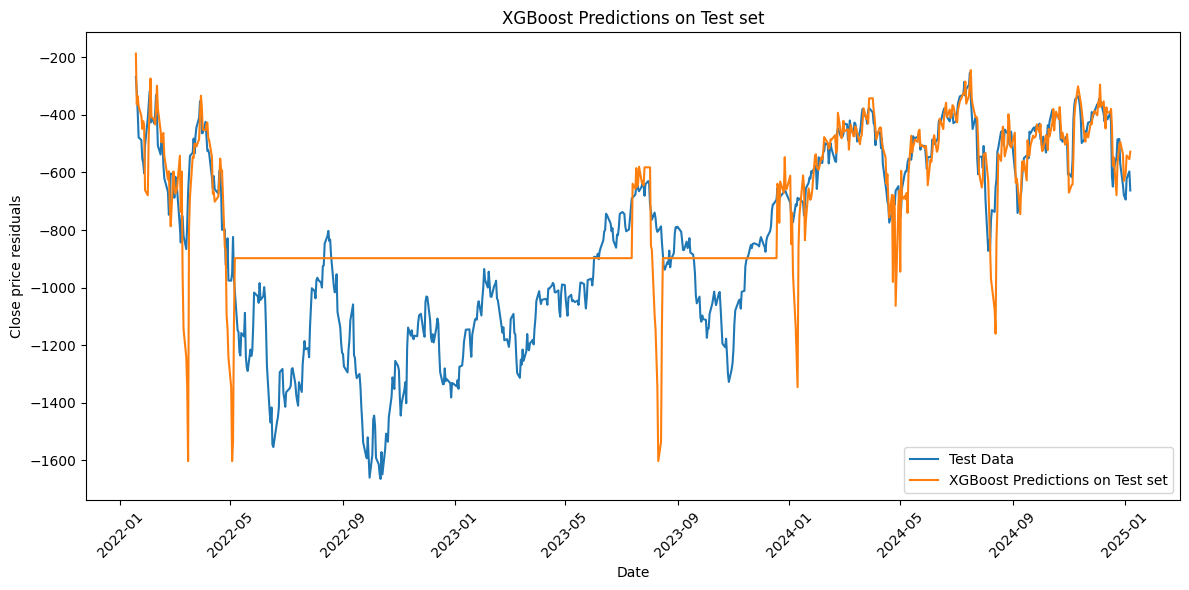

RMSE: 11.12606463535151
Mean Squared Error: 123.78931427001953
Mean Absolute Error: 7.912360191345215
R2 Score: 0.9951931238174438


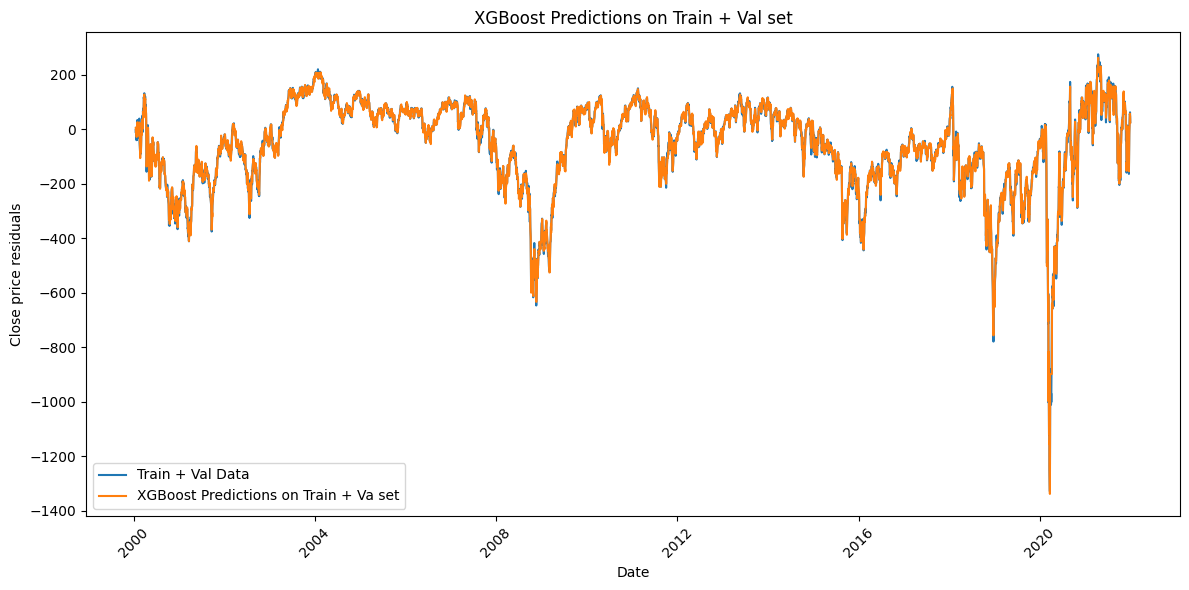

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


['/content/gdrive/MyDrive/università/Tesi/models/XGBoost_model_univariate_sliding_windows.joblib']

In [11]:
# train model using the best hyperparameters
# best_params ={'colsample_bytree': 0.808411208122622, 'early_stopping_rounds': 17, 'gamma': 0.0005022072348654649, 'learning_rate': 0.3196968954529591, 'max_depth': 14, 'num_boost_round': 1949, 'objective': 'reg:squarederror', 'subsample': 0.7712161804793591}
# best_params = {'colsample_bytree': 0.45298491613255965, 'early_stopping_rounds': 16, 'gamma': 0.0033010903221791198, 'learning_rate': 0.4062593003755195, 'max_depth': 10, 'num_boost_round': 1445, 'objective': 'reg:squarederror', 'subsample': 0.9637993843394563}
# best_params: {'colsample_bytree': 0.8363746113200037, 'early_stopping_rounds': 19, 'gamma': 0.003066575136600952, 'learning_rate': 0.30104358076393695, 'max_depth': 9, 'num_boost_round': 535, 'objective': 'reg:squarederror', 'subsample': 0.8306946262106537}

best_params = {'alpha': 0.07974876214479332, 'colsample_bytree': 0.4505624091260668, 'early_stopping_rounds': 20, 'gamma': 0.005882153523315466, 'lambda': 0.6591718388148139, 'learning_rate': 0.4770299725862893, 'max_depth': 10, 'num_boost_round': 1582, 'objective': 'reg:squarederror', 'subsample': 0.750301020293294}
# best_params = {'alpha': 0.3223045480428064, 'colsample_bytree': 0.7986340282443237, 'early_stopping_rounds': 20, 'gamma': 0.006850732712355683, 'lambda': 0.6185707666412035, 'learning_rate': 0.48612569577423054, 'max_depth': 7, 'num_boost_round': 784, 'objective': 'reg:squarederror', 'subsample': 0.9753460207084007}
model = xgb.train(best_params, dtrain_val, evals = [(dval, 'validation')], num_boost_round = best_params['num_boost_round'], early_stopping_rounds= best_params['early_stopping_rounds'], verbose_eval=False)  # Initialize xgboost model


#predictions
y_test_pred = model.predict(dtest)
y_train_val_pred = model.predict(dtrain_val)


#unscale predictions
y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1))
y_train_val_pred = scaler.inverse_transform(y_train_val_pred.reshape(-1, 1))


#compute metrics
mse = mean_squared_error(test_data[10:], y_test_pred)
rmse = np.sqrt(mean_squared_error(test_data[10:], y_test_pred))
mae = mean_absolute_error(test_data[10:], y_test_pred)
r2 = r2_score(test_data[10:], y_test_pred)
print(f'RMSE: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')


#visualize
plt.figure(figsize=(12, 6))
# sns.lineplot(x=val_data.index, y=val_data['Residuals'].values, label="Val Data")
sns.lineplot(x= test_data[10:].index, y = test_data[10:].squeeze(), label="Test Data")
sns.lineplot(x=test_data[10:].index, y=y_test_pred.squeeze(), label="XGBoost Predictions on Test set")
plt.title('XGBoost Predictions on Test set')
plt.xlabel('Date')
plt.ylabel('Close price residuals')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


mse = mean_squared_error(train_val_data[10:], y_train_val_pred)
rmse = np.sqrt(mean_squared_error(train_val_data[10:], y_train_val_pred))
mae = mean_absolute_error(train_val_data[10:], y_train_val_pred)
r2 = r2_score(train_val_data[10:], y_train_val_pred)
print(f'RMSE: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x= train_val_data[10:].index, y = train_val_data[10:].squeeze(), label="Train + Val Data")
sns.lineplot(x=train_val_data[10:].index, y=y_train_val_pred.squeeze(), label="XGBoost Predictions on Train + Va set")
plt.title('XGBoost Predictions on Train + Val set')
plt.xlabel('Date')
plt.ylabel('Close price residuals')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#save model on google drive
drive.mount("/content/gdrive")
file_path = '/content/gdrive/MyDrive/università/Tesi/models/XGBoost_model_univariate_sliding_windows.joblib'
dump(model, file_path)

##Combine ARIMA + XGBoost

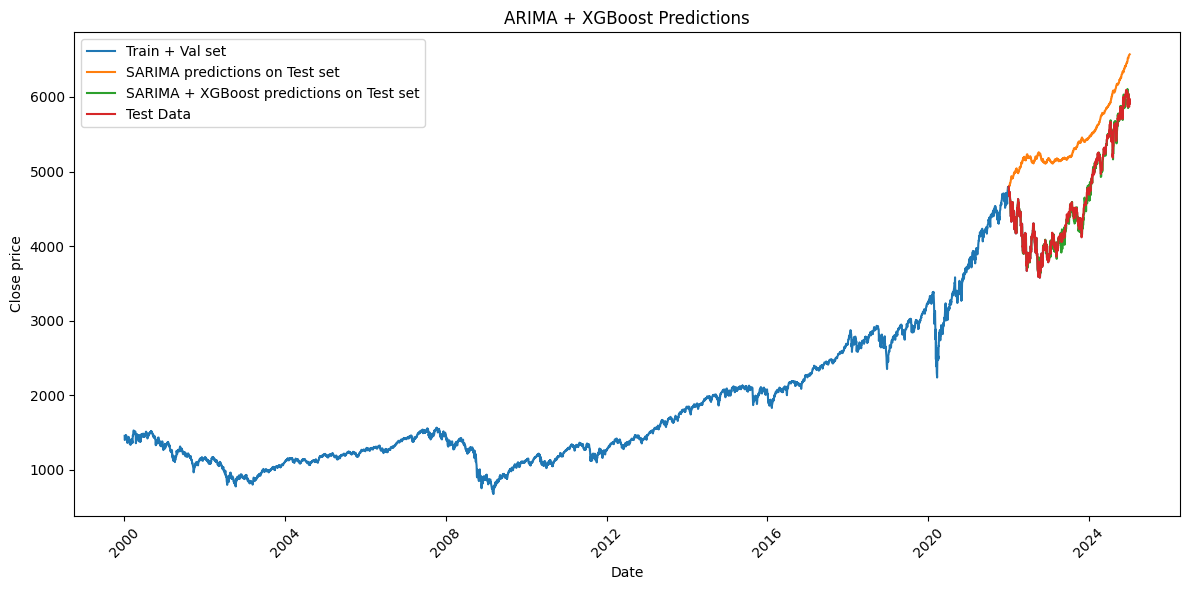

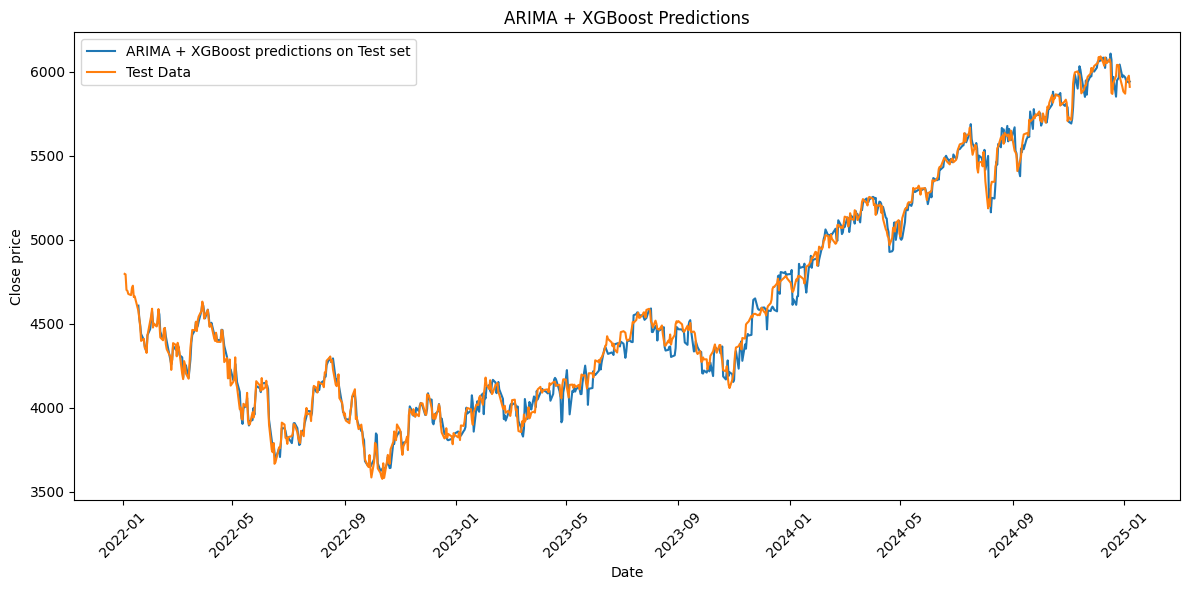

RMSE: 54.65960036596571
Mean Squared Error: 2987.671912167079
Mean Absolute Error: 40.6702508450928
R2 Score: 0.9933633326723577


In [5]:
SARIMA_XGBoost_predictions = SARIMA_test_predictions[10:] + y_test_pred.squeeze()

#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_val_data.index, y=Close_price.loc[train_val_data.index], label="Train + Val set")
sns.lineplot(x=test_data.index, y=SARIMA_test_predictions.values, label="SARIMA predictions on Test set")
# sns.lineplot(x=test_data.index, y=XGBoost_predictions.values.ravel(), label="XGBoost predictions")
sns.lineplot(x=test_data[10:].index, y=SARIMA_XGBoost_predictions, label="SARIMA + XGBoost predictions on Test set")
sns.lineplot(x=test_data.index, y=Close_price.loc[test_data.index ], label="Test Data")
plt.title('ARIMA + XGBoost Predictions')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#close up
plt.figure(figsize=(12, 6))
sns.lineplot(x=test_data[10:].index, y=SARIMA_XGBoost_predictions, label="ARIMA + XGBoost predictions on Test set")
sns.lineplot(x=test_data.index, y=Close_price.loc[test_data.index ], label="Test Data")
plt.title('ARIMA + XGBoost Predictions')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#compute metrics
mse = mean_squared_error(Close_price.loc[test_data[10:].index ], SARIMA_XGBoost_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Close_price.loc[test_data[10:].index ], SARIMA_XGBoost_predictions)
r2 = r2_score(Close_price.loc[test_data[10:].index ], SARIMA_XGBoost_predictions)
print(f'RMSE: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')


#save predictions
SARIMA_XGBoost_predictions = pd.Series(SARIMA_XGBoost_predictions, index=test_data.index)
path = "/content/gdrive/MyDrive/università/Machine_learning/Project_code/XGBoost/SARIMA_XGBoost_predictions.csv"
SARIMA_XGBoost_predictions.to_csv(path, index=True)

#Naive model

MSE:  570561.9042888356
RMSE:  755.3554820671096
MAE:  593.5665020938114
R2:  -1.4396191182451599


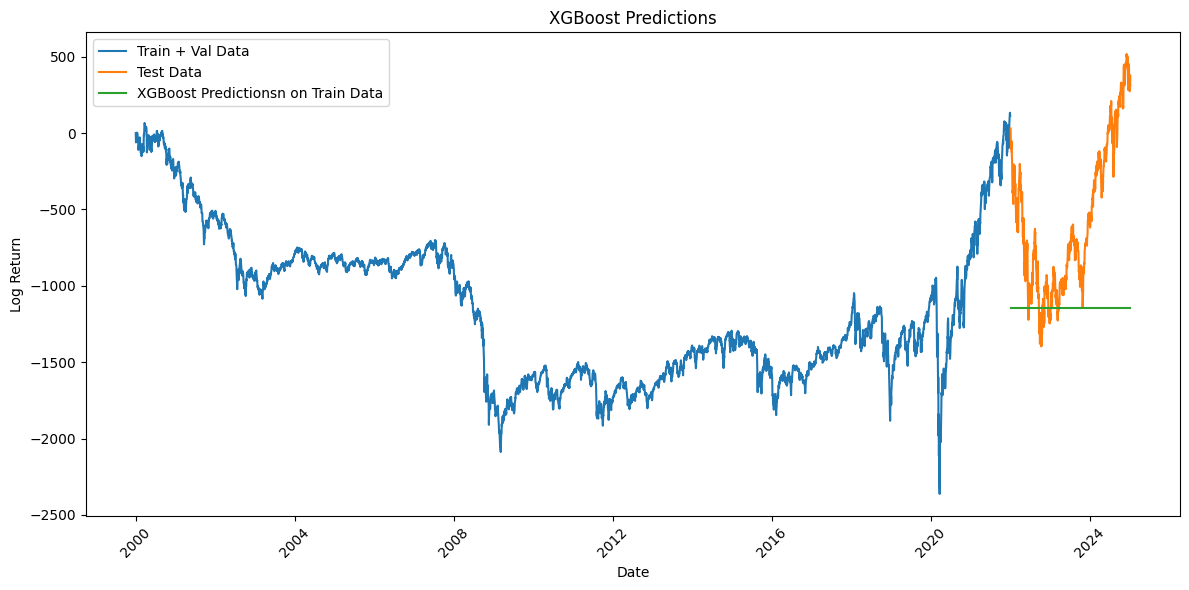

In [33]:
#naive model that predict the means
class naive_estimator:
    def __init__(self):
        self.mean_value = None  # Initialize mean

    def fit(self, train_data):
      self.mean_value = np.mean(train_data.iloc[:,0])

    def predict(self, test_data):
      return np.full(len(test_data), self.mean_value)  # Creates array of mean values


train_data = residuals.loc[: '2018']
train_data.index = pd.to_datetime(train_data.index)

val_data = residuals.loc['2019': '2021']
val_data.index = pd.to_datetime(val_data.index)

train_val_data = residuals.loc[: '2022']
train_val_data.index = pd.to_datetime(train_val_data.index)

test_data = residuals.loc['2022':]
test_data.index = pd.to_datetime(test_data.index)


#train + fit naive model
mean_esitmator = naive_estimator()
mean_esitmator.fit(train_val_data)
test_predictions = mean_esitmator.predict(test_data)


mse = mean_squared_error(test_data, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, test_predictions)
r2 = r2_score(test_data, test_predictions)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('R2: ', r2)


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_val_data.index, y=train_val_data.squeeze(), label="Train + Val Data")
sns.lineplot(x=test_data.index, y=test_data.squeeze(), label="Test Data")
sns.lineplot(x=test_data.index, y=test_predictions, label="XGBoost Predictionsn on Train Data")
plt.title('XGBoost Predictions')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()

#Linear Tree

In [3]:
!pip install --upgrade linear-tree

In [4]:
from sklearn.linear_model import LinearRegression
from lineartree import LinearBoostRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge

#ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [7]:
#univariate sliding window
train_data = residuals.loc[: '2018']
train_data.index = pd.to_datetime(train_data.index)

val_data = residuals.loc['2019': '2021']
val_data.index = pd.to_datetime(val_data.index)

train_val_data = residuals.loc[: '2021']
train_val_data.index = pd.to_datetime(train_val_data.index)

test_data = residuals.loc['2022':]
test_data.index = pd.to_datetime(test_data.index)


#scale the data
# scaler = MinMaxScaler(feature_range=(-1, 1)) #initilise scaler
# scaler = StandardScaler()

scaler = RobustScaler()
train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data.values.reshape(-1, 1)))
val_data_scaled = pd.DataFrame(scaler.transform(val_data.values.reshape(-1, 1)))
train_val_data_scaled = pd.DataFrame(scaler.fit_transform(train_val_data.values.reshape(-1, 1)))
test_data_scaled = pd.DataFrame(scaler.transform(test_data.values.reshape(-1, 1)))


def sliding_windows(data, seq_length):
    X, y = [], []

    for i in range(len(data) - seq_length ):
      _x = data.iloc[i:i+seq_length]
      _y = data.iloc[i + seq_length]
      X.append(_x)
      y.append(_y)

    return np.array(X), np.array(y)


#sliding windows
X_train, y_train  = sliding_windows(train_data_scaled, 10)
X_val, y_val= sliding_windows(val_data_scaled, 10)
X_test, y_test = sliding_windows(test_data_scaled, 10)
X_train_val , y_train_val = sliding_windows(train_val_data_scaled, 10)


# Flatten the sliding windows
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_train_val = X_train_val.reshape(X_train_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)


#convert to Dmatrix format
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dval = xgb.DMatrix(X_val, label=y_val)
# dtrain_val = xgb.DMatrix(X_train_val, label=y_train_val)
# dtest = xgb.DMatrix(X_test, label=y_test)

##Find the best hyperparameter using Bayesian Optimization

In [ ]:
!pip install arm-mango

In [ ]:
from mango import scheduler #to perform Bayesian optimization
from mango.tuner import Tuner
import time
from joblib import Parallel, delayed, dump, load
from scipy.stats import uniform


In [42]:
#parallel bayesian optimization
class OptimizationMangoParallel:
  def __init__(self, njobs: int, configuration_params: dict, X_train, y_train, X_val, y_val):
      self.conf_dict = configuration_params
      self.njobs = njobs
      self.X_train = X_train
      self.y_train = y_train
      self.X_val = X_val
      self.y_val = y_val
      self.space = {
        "n_estimators": range(50, 500),
        "max_depth": range(3, 15),
        "min_samples_split": range(2, 20),
        "min_samples_leaf": range(1, 20),
        "alpha": uniform(0.01, 10)
}





  #This is the loss function that mango optimizes
  def XGBoost_objetive_function(self, **params):
    try:
        n_estimators = params["n_estimators"]
        max_depth = params["max_depth"]
        min_samples_split = params["min_samples_split"]
        min_samples_leaf = params["min_samples_leaf"]
        alpha = params["alpha"]

        print(f"training: Ridge(alpha={alpha}), n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}")
        model = LinearBoostRegressor(base_estimator=Ridge(alpha=alpha), n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
        model.fit(self.X_train, self.y_train)

        #predict
        y_pred = model.predict(self.X_val)

        # unscale predictions
        y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

        rmse = np.sqrt(mean_squared_error(val_data[10:], y_pred)) # Compute RMSE
        # print(rmse)
        return rmse
    except Exception as e:
        print(f"Error with params {params}: {e}")
        return 1e5  # Penalize error cases


  def _objective2(self, params_batch):
    global parameters
    # print(f"Parameters batch: {params_batch}")
    results_batch = Parallel(self.njobs, backend="threading")(delayed(self.XGBoost_objetive_function)(**params) for params in params_batch)
    # print(f"Results batch: {results_batch}")
    rmse = [result for result in results_batch]
    return rmse


  def mango_optimization(self):
      tuner = Tuner(self.space, self._objective2, self.conf_dict)
      optimisation_results = tuner.minimize()
      return optimisation_results['best_params'], optimisation_results['best_objective']


# Parallel hyperparameters tuning
config_params = {'num_iteration': 40, 'initial_random': 10}
start_time = time.time()
optim = OptimizationMangoParallel(njobs=4, configuration_params=config_params, X_train=X_train, y_train=y_train, X_val=X_val , y_val = y_val) #initialize a new instance of the class
best_parameters, best_objective = optim.mango_optimization()
print(f'The optimisation in parallel takes {(time.time() - start_time) / 60.} minutes.')


# Inspect the results
print('best parameters:', best_parameters)
print('best accuracy:', best_objective)


training: Ridge(alpha=4.5495601298711), n_estimators=80, max_depth=7, min_samples_split=11, min_samples_leaf=4
training: Ridge(alpha=5.4067106399222755), n_estimators=434, max_depth=7, min_samples_split=19, min_samples_leaf=15
training: Ridge(alpha=2.4552703983651556), n_estimators=418, max_depth=13, min_samples_split=7, min_samples_leaf=8
training: Ridge(alpha=3.3980292476373286), n_estimators=164, max_depth=8, min_samples_split=9, min_samples_leaf=12
training: Ridge(alpha=0.8833371872877016), n_estimators=384, max_depth=13, min_samples_split=15, min_samples_leaf=15
training: Ridge(alpha=9.288599324934406), n_estimators=219, max_depth=7, min_samples_split=6, min_samples_leaf=15
training: Ridge(alpha=9.32408853625307), n_estimators=151, max_depth=6, min_samples_split=19, min_samples_leaf=12
training: Ridge(alpha=7.231786298751644), n_estimators=150, max_depth=9, min_samples_split=17, min_samples_leaf=16
training: Ridge(alpha=9.054851181938584), n_estimators=180, max_depth=12, min_sampl

  0%|          | 0/40 [00:00<?, ?it/s]

training: Ridge(alpha=4.274553332180867), n_estimators=333, max_depth=13, min_samples_split=8, min_samples_leaf=17
training: Ridge(alpha=7.931162386226106), n_estimators=178, max_depth=13, min_samples_split=12, min_samples_leaf=15
training: Ridge(alpha=4.653969682698455), n_estimators=132, max_depth=4, min_samples_split=17, min_samples_leaf=5
training: Ridge(alpha=8.580703440666161), n_estimators=178, max_depth=13, min_samples_split=12, min_samples_leaf=15
training: Ridge(alpha=4.375068421474742), n_estimators=262, max_depth=3, min_samples_split=9, min_samples_leaf=16
training: Ridge(alpha=8.966726161571813), n_estimators=282, max_depth=11, min_samples_split=12, min_samples_leaf=19
training: Ridge(alpha=6.967351852687329), n_estimators=199, max_depth=4, min_samples_split=19, min_samples_leaf=13
training: Ridge(alpha=5.26981950887192), n_estimators=80, max_depth=7, min_samples_split=11, min_samples_leaf=4
training: Ridge(alpha=1.7002133334522318), n_estimators=473, max_depth=8, min_samp

##Residual prediction

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr

RMSE: 54.71299182652485
Mean Squared Error: 2993.511474609375
Mean Absolute Error: 41.7406005859375
R2 Score: 0.9730474352836609


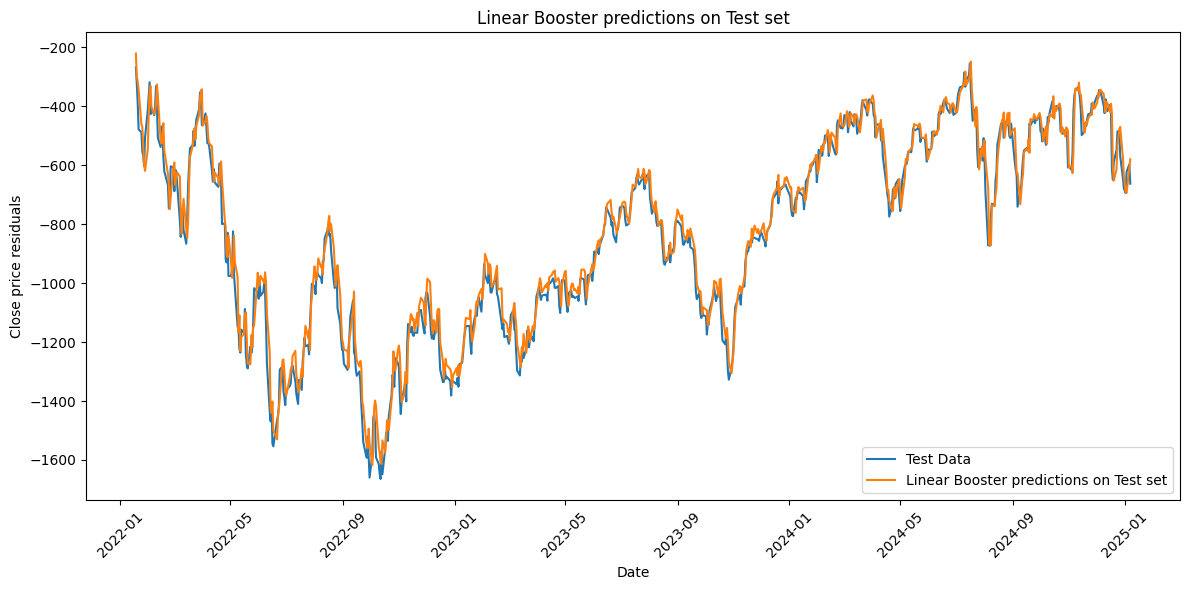

RMSE: 16.944629027537292
Mean Squared Error: 287.1204528808594
Mean Absolute Error: 11.139542579650879
R2 Score: 0.9888507723808289


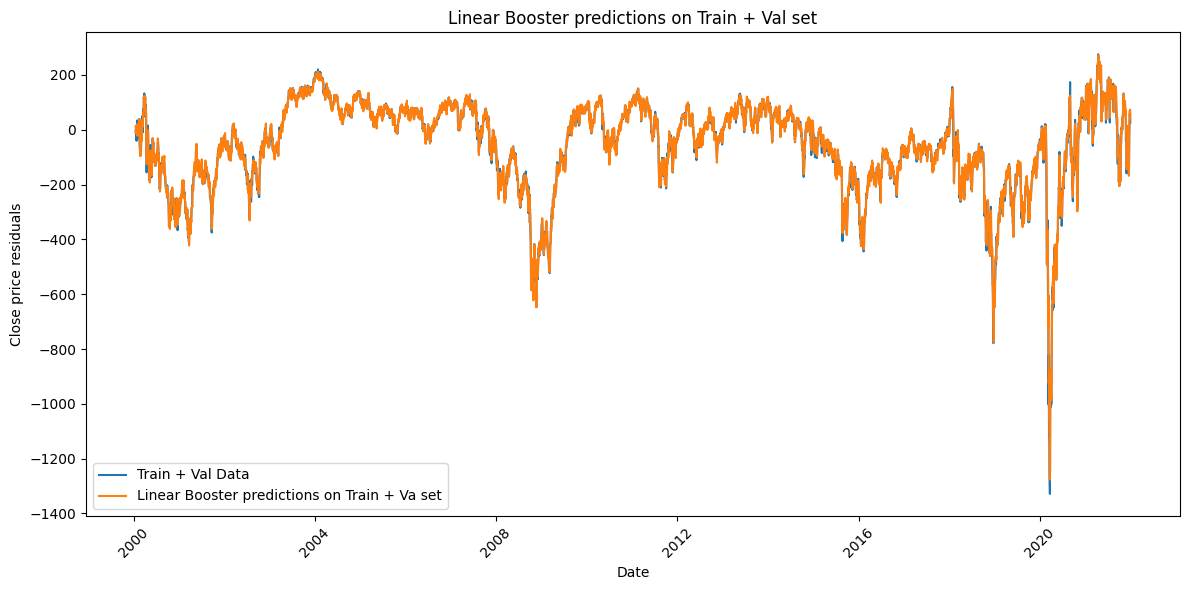

In [8]:
best_params = {"n_estimators": 300,  "max_depth": 5,  "min_samples_split" : 5, "min_samples_leaf" : 0.1}
# best_params = {'alpha': 3.7802575891260792, 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 10, 'n_estimators': 164}
# alpha = best_params["alpha"]
# best_params.pop('alpha', None)


#fit model
ridge = Ridge(alpha=0.1)
model = LinearBoostRegressor(base_estimator=ridge, **best_params)
model.fit(X_train_val, y_train_val)


#predictions
y_test_pred = model.predict(X_test)
y_train_val_pred = model.predict(X_train_val)


#unscale predictions
y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1))
y_train_val_pred = scaler.inverse_transform(y_train_val_pred.reshape(-1, 1))


#compute metrics
mse = mean_squared_error(test_data[10:], y_test_pred)
rmse = np.sqrt(mean_squared_error(test_data[10:], y_test_pred))
mae = mean_absolute_error(test_data[10:], y_test_pred)
r2 = r2_score(test_data[10:], y_test_pred)
print(f'RMSE: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')


#visualize
plt.figure(figsize=(12, 6))
# sns.lineplot(x=val_data.index, y=val_data['Residuals'].values, label="Val Data")
sns.lineplot(x= test_data[10:].index, y = test_data[10:].squeeze(), label="Test Data")
sns.lineplot(x=test_data[10:].index, y=y_test_pred.squeeze(), label="Linear Booster predictions on Test set")
plt.title('Linear Booster predictions on Test set')
plt.xlabel('Date')
plt.ylabel('Close price residuals')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


mse = mean_squared_error(train_val_data[10:], y_train_val_pred)
rmse = np.sqrt(mean_squared_error(train_val_data[10:], y_train_val_pred))
mae = mean_absolute_error(train_val_data[10:], y_train_val_pred)
r2 = r2_score(train_val_data[10:], y_train_val_pred)
print(f'RMSE: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x= train_val_data[10:].index, y = train_val_data[10:].squeeze(), label="Train + Val Data")
sns.lineplot(x=train_val_data[10:].index, y=y_train_val_pred.squeeze(), label="Linear Booster predictions on Train + Va set")
plt.title('Linear Booster predictions on Train + Val set')
plt.xlabel('Date')
plt.ylabel('Close price residuals')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#save model on google drive
# drive.mount("/content/gdrive")
# file_path = '/content/gdrive/MyDrive/università/Tesi/models/Linear_booster.joblib'
# dump(model, file_path)

##SARIMA + Linear booster

In [ ]:
ARIMA_XGBoost_predictions = ARIMA_predictions + XGBoost_predictions


#compute metrics
mse = mean_squared_error(Close_price.loc[test_data.index], ARIMA_XGBoost_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Close_price.loc[test_data.index], ARIMA_XGBoost_predictions)
r2 = r2_score(Close_price.loc[test_data.index], ARIMA_XGBoost_predictions)
print(f'RMSE: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_val_data.index, y=Close_price.loc[train_val_data.index], label="Close price")
sns.lineplot(x=test_data.index, y=ARIMA_predictions.values.ravel(), label="ARIMA predictions")
# sns.lineplot(x=test_data.index, y=XGBoost_predictions.values.ravel(), label="XGBoost predictions")
sns.lineplot(x=test_data.index, y=ARIMA_XGBoost_predictions, label="ARIMA + XGBoost predictions")
sns.lineplot(x=test_data.index, y=Close_price.loc[test_data.index ], label="Test Data")
plt.title('ARIMA + XGBoost Predictions')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()


#close up
plt.figure(figsize=(12, 6))
sns.lineplot(x=test_data.index, y=Close_price.loc[test_data.index ], label="Test Data")
sns.lineplot(x=test_data.index, y=ARIMA_XGBoost_predictions, label="ARIMA + XGBoost predictions")